<a href="https://colab.research.google.com/github/bendurand/hello-world/blob/main/LabAssignementNNwithKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: NN with Keras

This Notebook is adapted from A. Géron's "Hands-on ML" book and from Tensorflow official tutorials.

# Classifying images with a neural network

In [3]:
# import the necessary libraries
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import seaborn as sns
import os

## Importing tensorflow and keras

First let's import TensorFlow and Keras.

In [4]:
import tensorflow as tf
from tensorflow import keras

2022-10-17 12:12:14.898862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 12:12:15.071657: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-17 12:12:15.077283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-17 12:12:15.077303: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [5]:
tf.__version__

'2.10.0'

In [6]:
keras.__version__

'2.10.0'

## Tensors and Variables in Tensorflow

Tensors are the analogous of Numpy's `ndarrays` and represent multi-dimensional arrays of arbitrary shape.

In [7]:
t = tf.constant([1,2,3])
t

2022-10-17 12:12:20.684170: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-17 12:12:20.684226: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bdurand-Swift-SF314-57G): /proc/driver/nvidia/version does not exist
2022-10-17 12:12:20.684979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

They can be exported to numpy using the dedicated method:

In [8]:
t.numpy()

array([1, 2, 3], dtype=int32)

Tensorflow variables are a special type of tensor. They are used to represent values that are changed by your program (like the parameters of a network).

In [9]:
my_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
my_variable = tf.Variable(my_tensor)

Normally you won't need to explicitly create tensors and variables, but they are the underlying data structures used within keras layers.

## The data: Fashion MNIST

We will use [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. 

### Import and load the dataset

Keras has a number of functions to load popular datasets in `keras.datasets`. 
We can use this module to import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data).


In [10]:
fashion_mnist = keras.datasets.fashion_mnist  # type: ignore
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


Loading the dataset returns four NumPy arrays:

* The first pair `X_train_full` and `y_train_full` arrays are the *training set*
* The second pair  the `X_test` and `y_test` are the *test set*

### TODO: check the quantity of images in each set and their shape

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [11]:
# TODO your code here
X_train_full.shape

(60000, 28, 28)

In [12]:
y_train_full.shape

(60000,)

### Preprocess the data

Images are in grayscale. Each pixel intensity is represented as a byte (0 to 255):

In [13]:
X_train_full.dtype

dtype('uint8')

You can visualize it by plotting one of the training images:

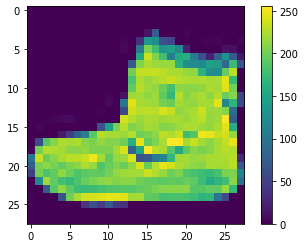

In [14]:
plt.figure()
plt.imshow(X_train_full[0])
plt.colorbar()
plt.grid(False)
plt.show()

#### TODO: rescaling pixel values

As seen in class, gradient terms for weights in the first layer include a product with the network inputs. This means the scaling of the inputs can influence the optimization convergence:
- large inputs will incurr in large gradients which incurr in large steps during optimization. Too large steps can bring instability.
- Features with un-even variation range lead to a poorly conditioned loss function (analogous to a very elongated quadratic form).

Therefore it is good practice to rescale neural network features. It is common to use MinMax scaling, so that features range between 0 and 1. Standardization is also a valid possibility (if you can assume your features have a Gaussian distribution)

In the case of image pixels, MinMax scaling can be done with a simple division, which you are going to do just bellow.

**Important**: *training set* and the *testing set* should be preprocessed in the same way.

In [15]:
# TODO your code here
X_train_full = X_train_full/255

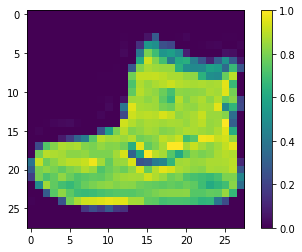

In [16]:
plt.figure()
plt.imshow(X_train_full[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [17]:
X_test = X_test/255

### TODO: Creating a validation set
The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set.
For this we'll split the full training set into a validation set and a (smaller) training set.
Separate 5000 images for the validation set.

In [18]:
# TODO your code here
X_train, X_valid = X_train_full[:55000], X_train_full[55000:]
y_train, y_valid = y_train_full[:55000], y_train_full[55000:]


In [19]:
X_train.shape

(55000, 28, 28)

In [20]:
X_valid.shape

(5000, 28, 28)

### Visualizing images and labels

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

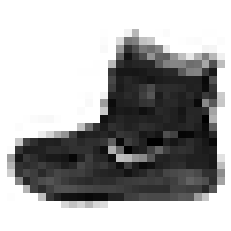

In [21]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs, stored in an array of integers (represented as uint8), ranging from 0 to 9:

In [22]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [23]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [24]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

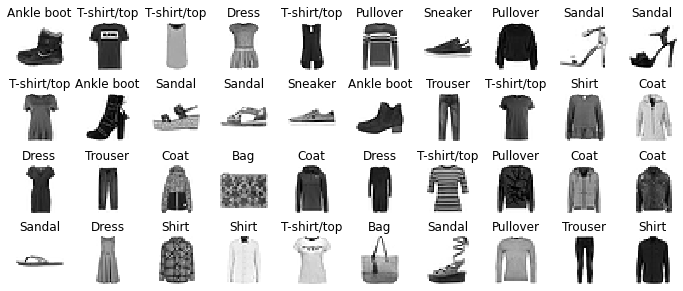

In [25]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

## Building models with tf.keras.Sequential

`tf.keras` offers you a high level API to implement neural networks easily.
Most models can be represented using the `tf.keras.Sequential` API.
For more complex models, we can use `tf.keras.functional` and/or sub-class `tf.keras.Model`.

Before creating our model, let's set our random states to control random initialization.

In [26]:
keras.backend.clear_session()  # type: ignore
np.random.seed(42)
tf.random.set_seed(42)

Let's start with an empty sequential model:

In [27]:
model = keras.models.Sequential()  # type: ignore
model

We can add the layers we wish to add to our model one by one using `model.add`.
First let us add a layer to vectorize the image inputs (2D into 1D):

In [28]:
model.add(keras.layers.Flatten(input_shape=[28, 28]))

Layers of the type `tf.keras.layers.Flatten` transform the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

### Hidden layers
We can add typical MLP layers using `keras.layers.Dense`.

In [29]:
model.add(keras.layers.Dense(300, activation="relu"))

The first argument defines the number of neurons in the layer. The activation parameter needs to be set to the desired activation function, otherwise you will simply have a linear layer.

#### TODO: Add another hidden layer
Add a second hidden layer with 100 units

In [30]:
# TODO your code here
model.add(keras.layers.Dense(100, activation="relu"))  # type: ignore

### Output layer
For the output layer, the number of units is determined by the number of classes. Each unit computes a score that indicates the current image belongs to one of the 10 classes. 
By usiing softmax as the activation function, we obtain normalized probabilities as scores (as in the multinomial logistic regression).

In [31]:
model.add(keras.layers.Dense(10, activation="softmax"))

You can also create the same model by giving a list of these layers as argument to `keras.Sequential`:
``` python
keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
```

### Layers and weights
In any case, `model.layers` will contain a list of `keras.layers` at the end:

In [32]:
model.layers

Each layer has a name. You can attribute one during its creation. If you don't, a standard one will be created for you:

In [33]:
for layer in model.layers:
    print(layer.name)

flatten
dense
dense_1
dense_2


You can access your model's layers by indexing `model.layers` or by their name (using `model.get_layer`)

In [34]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [35]:
model.get_layer(hidden1.name) is hidden1

True

All the parameters of a layer can be accessed using its get_weights() and set_weights() methods. For a Dense layer, this includes both the connection weights and the bias terms:

In [36]:
weights, biases = hidden1.get_weights()

We can save this initial weights for later using `model.save_weights`, in case we want to reset our model to its initial state:

In [37]:
model.save_weights('init.h5')

`h5` is the extension corresponding to the default keras format, HDF5. To load back the weights, just call 
```python 
model.load_weights('init.h5')
```


### TODO: Check weights and biases values and shape

In [38]:
# TODO your code here
model.weights

[<tf.Variable 'dense/kernel:0' shape=(784, 300) dtype=float32, numpy=
 array([[ 9.0772063e-03, -2.7762294e-02, -6.9023415e-02, ...,
         -2.5981434e-02,  5.7675660e-02, -9.4684809e-03],
        [ 7.3113486e-02,  1.7750785e-02, -7.0341803e-02, ...,
          7.7888370e-05,  6.3322753e-02,  5.3106248e-03],
        [ 9.8270923e-04,  5.7575375e-02, -3.9577674e-02, ...,
         -5.0750837e-02, -5.0738901e-02, -3.0530784e-02],
        ...,
        [-6.3321374e-02, -1.6761050e-02,  3.3827543e-02, ...,
          2.3739882e-02,  1.2663424e-02, -2.9620975e-02],
        [ 1.5629500e-02, -2.3165777e-02, -7.0213400e-02, ...,
         -6.7144535e-02,  2.6532941e-02,  1.7796725e-02],
        [-2.5566474e-02, -6.2226504e-04,  4.4477507e-03, ...,
          2.2275656e-02,  3.3301599e-02, -6.9107421e-02]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(300,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.,

Notice that the Dense layer initialized the connection weights randomly, and the biases were initialized to zeros, which is fine. If you ever want to use a different initialization method, you can set kernel_initializer (kernel is another name for the matrix of connection weights) or bias_initializer when creating the layer. We will discuss initializers later, but if you want the full list, see https://keras.io/initializers/.

### Printing the model summary
The model’s summary() method displays all the model’s layers, including each layer’s
name (which is automatically generated unless you set it when creating the layer), its output shape (None means the batch size can be anything), and its number of parameters. The summary ends with the total number of parameters, including trainable and non-trainable parameters. Here we only have trainable parameters (we will see examples of non-trainable parameters later when doing some transfer learning):

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


You can use the utility function `keras.utils.plot_model` to visualize a graph of the network you just created:

In [40]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Compile the model

After a model is created, you must call its compile() method to specify the loss function and the optimizer to use. Optionally, you can specify a list of extra metrics to compute during training and evaluation:

In [41]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

We need to use the `sparse` version of the categorical cross entropy because our labels are not one-hot encoded:

In [42]:
y_train[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

If they were already encoded, we would use `categorical_crossentropy` directly.

You can change set SGD's learning rate during the call to compile:
```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

Or you can change it later by acessing `model.optimizer`:

In [43]:
model.optimizer.learning_rate = 0.01

## Training the model

Now the model is ready to be trained. For this we simply need to call its fit() method.

As arguments, we provide the training samples and labels. We can also set some keyword arguments adjust the training procedure:

In [44]:
history = model.fit(X_train, y_train, epochs=3,
                    validation_data=(X_valid, y_valid))

Epoch 1/3
1719/1719 [==============================] - 3s 1ms/step - loss: 0.7231 - accuracy: 0.7645 - val_loss: 0.5087 - val_accuracy: 0.8266
Epoch 2/3
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4873 - accuracy: 0.8318 - val_loss: 0.4721 - val_accuracy: 0.8310
Epoch 3/3
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4412 - accuracy: 0.8454 - val_loss: 0.4292 - val_accuracy: 0.8482


In [45]:
?model.fit

Signature:
model.fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose='auto',
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)
Docstring:
Trains the model for a fixed number of epochs (iterations on a dataset).

Args:
    x: Input data. It could be:
      - A Numpy array (or array-like), or a list of arrays
        (in case the model has multiple inputs).
      - A TensorFlow tensor, or a list of tensors
        (in case the model has multiple inputs).
      - A dict mapping input names to the corresponding array/tensors,
        if the model has named inputs.
      - A `tf.data` dataset. Should return a tuple
        of either `(inputs, targets)` or
        `(inputs, targets, sam

### Plotting learning curves
`model.fit` returns a history object that logs loss values for training and validation sets, as well as accuracy values (because we set it as a metric during the `compile` step).

In [46]:
history.params

{'verbose': 1, 'epochs': 3, 'steps': 1719}

In [47]:
history.epoch

[0, 1, 2]

In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
def plot_learning_curves(history):
    df = pd.DataFrame(history.history, index=np.array(history.epoch)+1)
    df.plot(figsize=(8, 5), fontsize=12)
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel('epochs', fontsize=12)
    plt.title ('learning curves', fontsize=12)
    plt.legend(fontsize=12)
    plt.show()

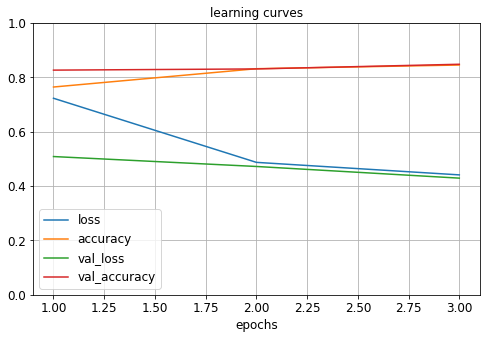

In [50]:
plot_learning_curves(history)

## Evaluating and making predictions on the test set

You can use the methods `model.evaluate` and `model.predict` on the test set:

In [51]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 869us/step - loss: 0.4628 - accuracy: 0.8369


[0.46281155943870544, 0.836899995803833]

In [52]:
y_proba = model.predict(X_test)

313/313 [==============================] - 0s 741us/step


Let's see the predictions for the first 3 images:

In [53]:
y_proba.round(2)[:3,:]

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.25, 0.  , 0.62],
       [0.  , 0.  , 0.86, 0.  , 0.02, 0.  , 0.12, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

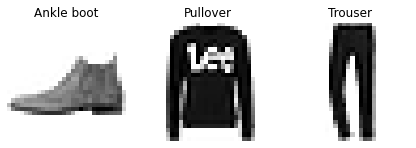

In [54]:
# First 3 images
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_test[:3]):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

The model outputs a vector per sample, containing the predicted class distributions. You can obtain most likely class id by finding the one with the highest probability:

In [55]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_pred[:3]

313/313 [==============================] - 0s 803us/step


array([9, 2, 1])

### TODO: Check your predicitons
Print the corresponding labels for these predictions and check if they are correct

In [56]:
# TODO your code here
print(class_names[y_pred[0]])
print(class_names[y_pred[1]])
print(class_names[y_pred[2]])

Ankle boot
Pullover
Trouser


### Plotting predicted class distributions

Here is some useful plotting code to visualize images alongside their predicted probabilities.

In [57]:
def plot_image(i, predictions, true_label, img):
    true_label, img = true_label[i], img[i]
    pred_probas = predictions[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(pred_probas)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    xlabel = "{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(pred_probas),
                                class_names[true_label])
    plt.xlabel(xlabel, color=color, fontsize=12)

def plot_probas(i, predictions, true_label):
    # Color correct predictions in blue and incorrect predictions in red.
    true_label = true_label[i]
    pred_probas = predictions[i]
    plt.grid(False)
    plt.xticks(range(10), labels=class_names, rotation=90, fontsize=12)
    plt.yticks([])
    thisplot = plt.bar(range(10), pred_probas, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(pred_probas)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

def plot_image_with_preds(i, X_test, y_test, y_proba):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plot_image(i, y_proba, y_test, X_test)
    plt.subplot(1,2,2)
    plot_probas(i, y_proba,  y_test)
    

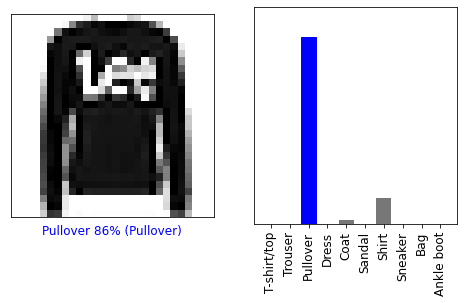

In [58]:
i = 1
plot_image_with_preds(i, X_test, y_test, y_proba)
plt.show()

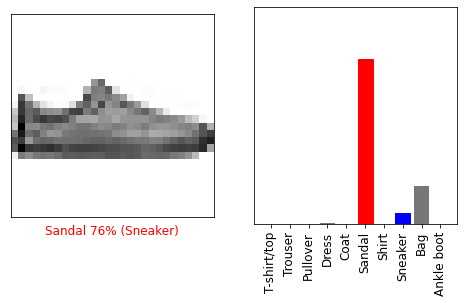

In [59]:
i = 12
plot_image_with_preds(i, X_test, y_test, y_proba)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

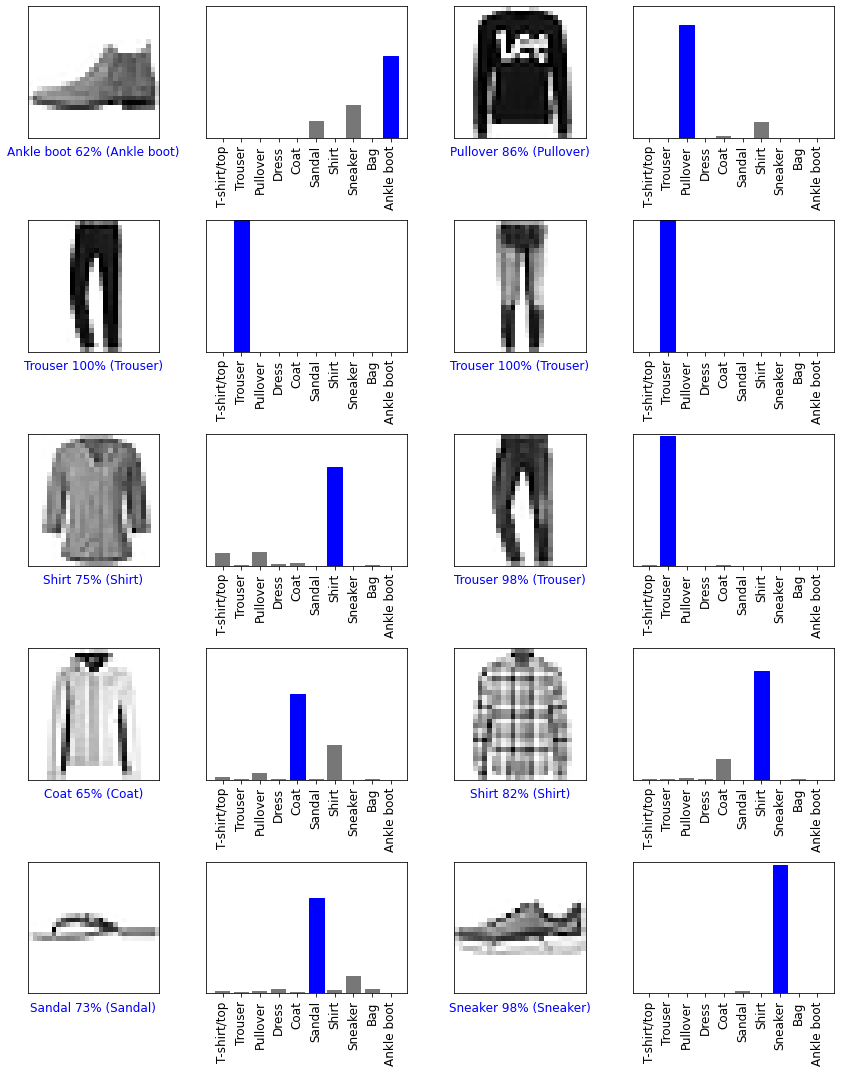

In [60]:
# Plot the first X test images, their predicted labels, and the true labels.
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*3*num_cols, 3*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, y_proba, y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_probas(i, y_proba, y_test)
plt.tight_layout()
plt.show()

## Using Callbacks during Training
The `fit()` method accepts a `callbacks` argument that lets you specify a list of objects that Keras will call at the start and end of training, at the start and end of each epoch, and even before and after processing each batch. For example, the `ModelCheckpoint` callback saves checkpoints of your model at regular intervals during training, by default at the end of each epoch:

In [61]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

With the `save_best_only` parameter set, only the weights corresponding to the best model on validaiton are kept. This allows us to easily rollback to the best model after some epochs of training:
``` python
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
acc_test = model.evaluate(X_test, y_test)
```

Callbacks can be used to implement early stopping and learning rate decay schedules. It is also possible to sub-class `keras.callbacks.Callback` and implement your own custom callback. You can check a list of the available callbacks in the [tf.keras docs](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) or in the [keras.io docs](https://keras.io/api/callbacks/).

In [62]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_cb = keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=10)

We will also use a callback to log metrics for visualization with Tensorboard:

In [63]:
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y.%m.%d_%H:%M:%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir
# callback creation
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

### TensorBoard
Tensorboard is a tool allowing visualization of metrics logged during the training of a model. You can use it within colab (or jupyter) by loading the tensorboard extension:

In [64]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

To start TensorBoard within the notebook, use the dedicated magic command (you need to give the same root log directory passed to the tensorboard callback):

In [65]:
%tensorboard --logdir my_logs

You can now view dashboards such as scalars, graphs, histograms, and others. If you launch new runs using the tensorboard callback (which is linked to this log directory `my_logs`) they should apear in the interface imediately, allowing you live monitoring the evolution of your training.


### TODO: retrain model with callbacks
Let's train our model for a longer number of epochs using all the previous callbacks. 
You can set a large number of epochs since early stopping is in place. Plot the learning curves and decide if your model is underfitting or overfitting.

In [66]:
history = model.fit(
    # TODO your code here
    X_train, y_train, epochs=20,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb,early_stopping_cb,lr_cb,tensorboard_cb]
)
model = keras.models.load_model("my_keras_model.h5") # rollback to best model

acc_test = model.evaluate(X_test, y_test)

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4149 - accuracy: 0.8553 - val_loss: 0.4208 - val_accuracy: 0.8490 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3958 - accuracy: 0.8626 - val_loss: 0.4021 - val_accuracy: 0.8556 - lr: 0.0100
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3786 - accuracy: 0.8667 - val_loss: 0.3880 - val_accuracy: 0.8628 - lr: 0.0100
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3672 - accuracy: 0.8718 - val_loss: 0.3700 - val_accuracy: 0.8674 - lr: 0.0100
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3553 - accuracy: 0.8746 - val_loss: 0.3713 - val_accuracy: 0.8656 - lr: 0.0100
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3445 - accuracy: 0.8781 - val_loss: 0.3753 - val_accuracy: 0.8702 - lr: 0.0100
Epoch 7/20
1719/1719 [==============================] - 3s

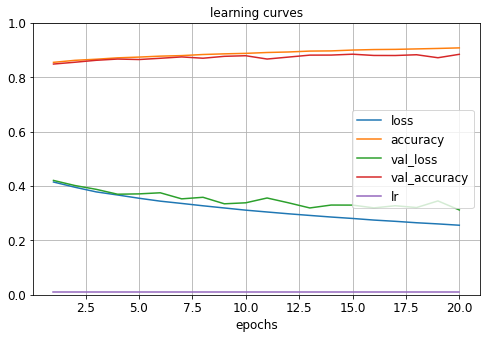

In [67]:
plot_learning_curves(history)

### TODO: check your model quality on out-of-set images
Now we test our model on a clothing item image from the web.



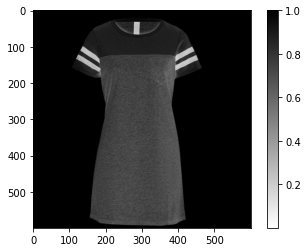

In [69]:
import urllib
from skimage.io import imread
from skimage.transform import resize

# insert the URL to an image file here
img_src = 'https://i.pinimg.com/736x/b5/b7/3e/b5b73ef74c015829bcaddfeb86081817--tee-shirt-dresses-tee-shirts.jpg'

# Download image
urllib.request.urlretrieve(img_src, 't-shirt-dress.jpg')

# Open file and display
image = imread('t-shirt-dress.jpg', as_gray=True) 

# Plot the image
plt.imshow(image, cmap='binary')
plt.colorbar()


**Important**: remember your model takes in grayscale images of 28 by 28 pixels. Remember as well that pixel values were rescaled to be between 0 and 1: ensure the new image pixel values are scaled to the same range.

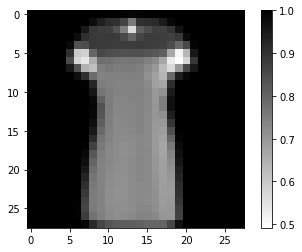

In [72]:
# TODO apply MinMax scaling to the image
image = (image-np.min(image))/(np.max(image)-np.min(image)) # TODO your code here

# TODO Resize image so it is 28 x 28 pixels
image = resize(image,(28,28)) # TODO your code here

# Plot the transformed image
plt.imshow(image, cmap='binary')
plt.colorbar()

In case your image has black instead of white background,  you need to reverse the colors: black should become white and white shouls become black. Complete the code bellow to do that:

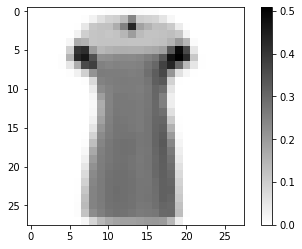

In [73]:
# TODO Invert black and white
image = 1-image # TODO your code here

# now the image has white background
plt.imshow(image, cmap='binary')
plt.colorbar()

Checking the class_names array again:

In [74]:
class_names 

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

We can say the predicted class id should be 3:

In [75]:
true_label = [3]

Let's see if the model gets it right:

In [76]:
# load model weights
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
# add batch dimension to image
image = image.reshape((1, 28, 28))
# compute predictions
y_proba = model.predict(image)
y_proba.round(3)

1/1 [==============================] - 0s 96ms/step


array([[0.179, 0.008, 0.042, 0.676, 0.004, 0.001, 0.071, 0.009, 0.008,
        0.   ]], dtype=float32)

In [77]:
pred_label = y_proba.argmax()
print(f"Predicted class was {class_names[pred_label]} (id {pred_label})")

Predicted class was Dress (id 3)


Let us now plot the image along with its predicted probabilities:

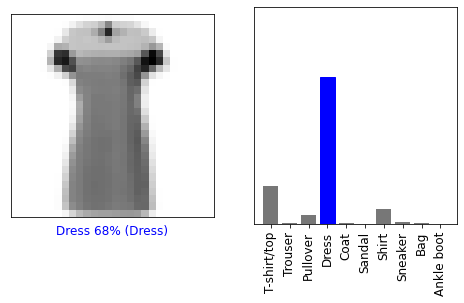

In [78]:
plot_image_with_preds(0, image, true_label, y_proba)
plt.show()

### TODO Your turn testing on downloaded images
Search online for other clothing item images that you can download and submit to your model. How well does it perform?


## Exercise: training an NN on MNIST
Train a similar MLP on the MNIST dataset (you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. 

- Try searching for the optimal learning rate by using the approach presented in class (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). 

  - Create a custom callback that will raise the learning rate by a factor (say, 5%) after each iteration (i.e. after each batch is processed). Check the documentation [here](https://keras.io/guides/writing_your_own_callbacks/) to see examples of how to create your own callback.

- Try adding all the bells and whistles: save checkpoints, use early stopping, and plot learning curves using TensorBoard.

- Visualize predictions for the test set and explore the mistakes your model makes.

In [86]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [87]:
X_train_full.shape

(60000, 28, 28)

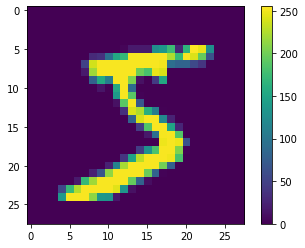

In [82]:
plt.figure()
plt.imshow(X_train_full[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [88]:
X_train_full = (X_train_full-np.min(X_train_full))/(np.max(X_train_full)-np.min(X_train_full))
X_test = (X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test))

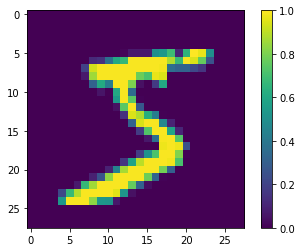

In [85]:
plt.figure()
plt.imshow(X_train_full[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [90]:
X_train, X_valid = X_train_full[:55000], X_train_full[55000:]
y_train, y_valid = y_train_full[:55000], y_train_full[55000:]

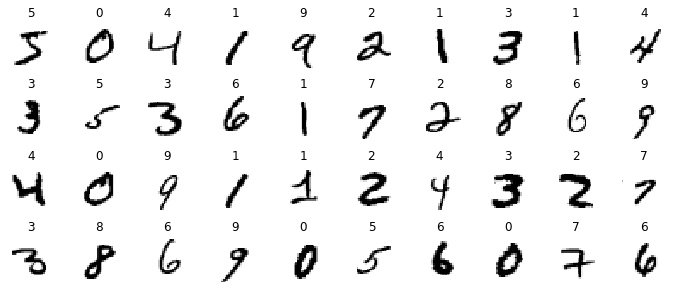

In [91]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [92]:
keras.backend.clear_session()  # type: ignore
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential()  # type: ignore
model

In [93]:
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(250, activation="relu"))
model.add(keras.layers.Dense(200, activation="relu"))
model.add(keras.layers.Dense(150, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [95]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 250)               75250     
                                                                 
 dense_2 (Dense)             (None, 200)               50200     
                                                                 
 dense_3 (Dense)             (None, 150)               30150     
                                                                 
 dense_4 (Dense)             (None, 100)               15100     
                                                                 
 dense_5 (Dense)             (None, 50)                5

In [96]:
keras.utils.plot_model(model, "my_numbers_mnist_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
